# Setup, Constants, and Imports

In [8]:
import os
import sys
import logging

## Notebook Configs

In [9]:
IS_COLAB = 'google.colab' in sys.modules
OUTPUT_PROCESSED_FILES = True # TODO: Use this if you want to output save files (optional - see below)

if IS_COLAB:
    from google.colab import userdata
    GITHUB_USERNAME = userdata.get('github_user')
    GITHUB_TOKEN = userdata.get('github_token')
    GITHUB_EMAIL = userdata.get('github_email')

## Constants

In [10]:
REPO_URL = "https://github.com/EErlando/Quarterly-Bytes.git"
REPO_NAME = "src"
REPO_BRANCH = "main" # TODO: UPDATE THIS TO YOU BRANCH - DEFAULT TO MAIN
ALL_TRANSCRIPTS_PATH = "data/raw/JP Morgan/Transcripts"
NOTEBOOK_DIR = "notebooks" # TODO: UPDATE THIS TO YOUR NOTEBOOK DIRECTORY (e.g. 1_data_extraction_and_processing)

## Clone and Pull Latest from Repository - Colab Specific

In [11]:
if IS_COLAB:
    !git config pull.rebase false
    if os.path.exists(REPO_NAME):
        print(f"Directory '{REPO_NAME}' already exists. Pulling latest changes...")
        %cd {REPO_NAME}
        !git pull origin {REPO_BRANCH} --quiet
        %cd ..
    else:
        print(f"Cloning repository into '{REPO_NAME}'...")
        !git clone --quiet --branch {REPO_BRANCH} {REPO_URL} {REPO_NAME}
        print("Clone complete.")

    sys.path.append('/content/src/')
    %cd /content/src/
    !pip install -r requirements.txt
else:
    !pip install -r requirements.txt
    if os.path.basename(os.getcwd()) == NOTEBOOK_DIR:
        os.chdir('../') # TODO: UPDATE THIS TO ROOT OF REPO

logging.basicConfig(level=logging.ERROR, format='%(levelname)s: %(message)s')

Directory 'src' already exists. Pulling latest changes...
/content/src/src
/content/src
/content/src


In [12]:
import nltk
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import seaborn as sns
import re

In [13]:
jp_morgan_md_df = pd.read_csv('/content/src/data/processed/JP Morgan/qna_df.csv')
display(jp_morgan_md_df.head())


,question_order,question_answer_group_id,speaker,role,company,content,year,quarter
0,0,0,John E. McDonald,Analyst,Autonomous Research,"Thank you. Morning, Jeremy. Was wondering abou...",2022,1
1,1,0,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Good morning, John. Good question. Yeah, look,...",2022,1
2,2,0,John E. McDonald,Analyst,Autonomous Research,"Okay. And as my follow up, could you give us s...",2022,1
3,3,0,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,Yeah. I guess I would direct you to my comment...,2022,1
4,4,0,John E. McDonald,Analyst,Autonomous Research,Okay. Thanks.,2022,1


In [15]:
# Grouping content by question_answer_group_id
grouped_df = jp_morgan_md_df.groupby('question_answer_group_id')['content'].apply(' '.join).reset_index()

# Display grouped data for verification
print(grouped_df.head())

   question_answer_group_id                                            content
0                         0  Thank you. Morning, Jeremy. Was wondering abou...
1                         1  ...if you're on –  yeah. Thank you. Good morni...
2                         2  Good morning. I guess just a coupl e of follow...


In [17]:
!pip install sumy

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 63.3 MB/s eta 0:00:00
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21693 sha256=b3ae01ded47d6139d014b469bdc329dd1670ff5a6ef622dc6a7a1b4d93c9109d
  Stored in directory: /root/.cache/pip/wheels/4d/57/58/7e3d7fedf51fe248b7fcee3df6945ae28638e22cddf01eb92b
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=4c6516ac4346dfef660c2608a70f3227c0bddcd56c362c5b9cd02bc692f223ca
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built breadability docopt


In [24]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
import nltk
nltk.download('punkt_tab')

# Define a summarization function
def summarize_text(text, num_sentences=2):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, num_sentences)
    return ' '.join([str(sentence) for sentence in summary])

# Apply summarization to the grouped DataFrame
grouped_df['summary'] = grouped_df['content'].apply(lambda x: summarize_text(x, num_sentences=3))

# Verify summaries
print(grouped_df[['question_answer_group_id', 'summary']].head())


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


   question_answer_group_id                                            summary
0                         0  So then if you line that up against the sort o...
1                         1  But I think more broadly on be nchmarking ours...
2                         2  So I think, yeah, you're referring to my comme...


In [25]:
grouped_df.to_csv('qa_grouped_with_summaries.csv', index=False)

In [26]:
# Add word count columns
grouped_df['orig_length'] = grouped_df['content'].apply(lambda x: len(x.split()))
grouped_df['summary_length'] = grouped_df['summary'].apply(lambda x: len(x.split()))

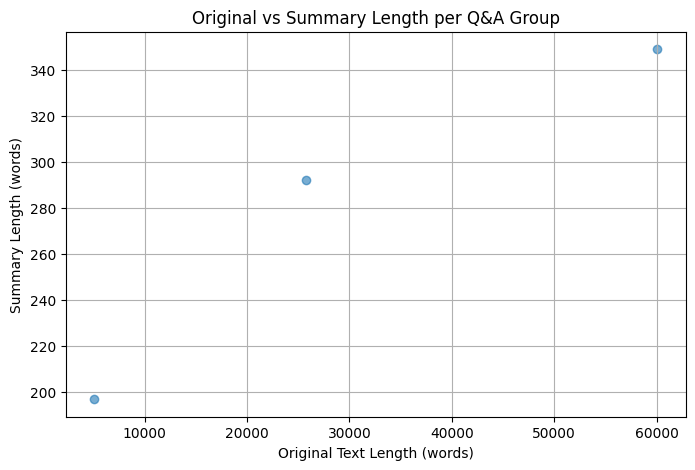

In [27]:
# Plot Original vs Summary Length

plt.figure(figsize=(8,5))
plt.scatter(grouped_df['orig_length'], grouped_df['summary_length'], alpha=0.6)
plt.xlabel('Original Text Length (words)')
plt.ylabel('Summary Length (words)')
plt.title('Original vs Summary Length per Q&A Group')
plt.grid(True)
plt.show()


In [29]:
print(grouped_df[['question_answer_group_id', 'orig_length', 'summary_length']])


   question_answer_group_id  orig_length  summary_length
0                         0        60088             349
1                         1        25795             292
2                         2         5033             197


In [30]:
longest = grouped_df.loc[grouped_df['summary_length'].idxmax()]
print("Longest Summary Q&A Group:", longest['question_answer_group_id'])
print("Summary Length:", longest['summary_length'])
print("Summary Text:", longest['summary'])

shortest = grouped_df.loc[grouped_df['summary_length'].idxmin()]
print("\nShortest Summary Q&A Group:", shortest['question_answer_group_id'])
print("Summary Length:", shortest['summary_length'])
print("Summary Text:", shortest['summary'])


Longest Summary Q&A Group: 0
Summary Length: 349
Summary Text: So then if you line that up against the sort of rising minimums, of course, we have the increase in the GSIB requirement in t he first quarter of 2023 com ing in and then there's the question of SCB where we don't know obviously, but given the countercyclical nature of the stress  and the fact that the unemployment launch point is a lot lower and the unemployment rate is floored in the Fed's scenario, you mig ht expect SCB to be a little bit higher when it's published in June effective in the fourth quarter. And I think that last point of Jamie's is particularly important because, sure, if you want, you can construct what I would c onsider a very optimistic argument that the higher cost of doing business will lead smaller scale players to exit and that's a shar e gain opportunity for us, but if I refer back to the comments about the disincentives to beneficial diversification and scale, getting bigger, especially i n market

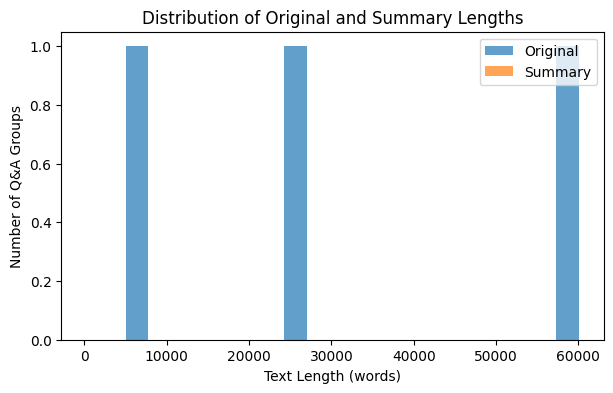

In [31]:
plt.figure(figsize=(7,4))
plt.hist(grouped_df['orig_length'], bins=20, alpha=0.7, label='Original')
plt.hist(grouped_df['summary_length'], bins=20, alpha=0.7, label='Summary')
plt.xlabel('Text Length (words)')
plt.ylabel('Number of Q&A Groups')
plt.title('Distribution of Original and Summary Lengths')
plt.legend()
plt.show()


In [28]:
# Find Q&A group with the longest summary
longest = grouped_df.loc[grouped_df['summary_length'].idxmax()]
print("Longest Summary Q&A Group:")
print(longest[['question_answer_group_id', 'summary_length', 'summary']])

# Find Q&A group with the shortest summary
shortest = grouped_df.loc[grouped_df['summary_length'].idxmin()]
print("\nShortest Summary Q&A Group:")
print(shortest[['question_answer_group_id', 'summary_length', 'summary']])


Longest Summary Q&A Group:
question_answer_group_id                                                    0
summary_length                                                            349
summary                     So then if you line that up against the sort o...
Name: 0, dtype: object

Shortest Summary Q&A Group:
question_answer_group_id                                                    2
summary_length                                                            197
summary                     So I think, yeah, you're referring to my comme...
Name: 2, dtype: object


# Save Data Example

In [ ]:
import nltk
nltk.download('punkt_tab')